In [95]:
import PIL
import glob
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [96]:
base_dir = "../data/severstal-steel-defect-detection/"
csv_path = os.path.join(base_dir, "train.csv")

df = pd.read_csv(csv_path)

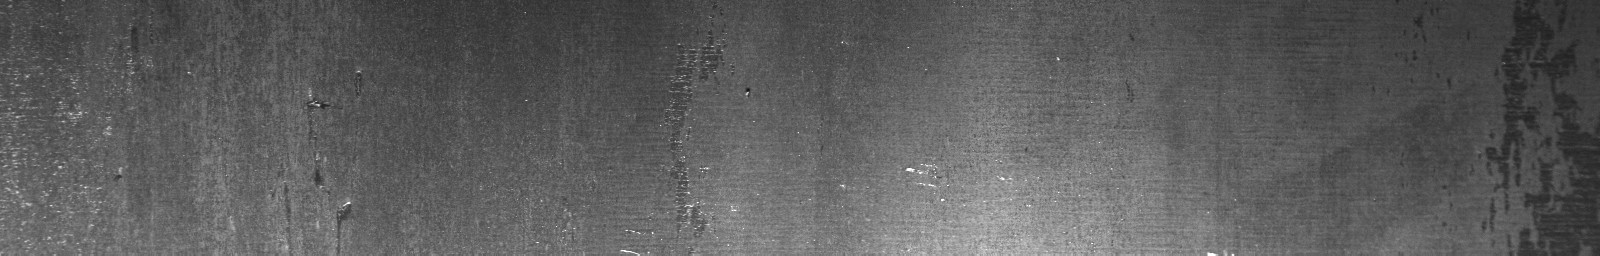

In [97]:
PIL.Image.open(os.path.join(base_dir,"train_images", df["ImageId"][0]))

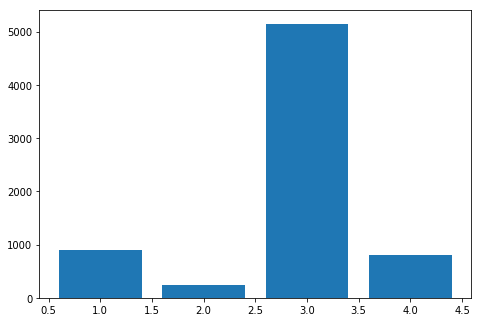

In [98]:
nunique = df["ClassId"].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(nunique.index, nunique)
plt.show()

In [99]:
# df["EncodedPixels"] = df["EncodedPixels"].apply(lambda x: list(map(int, x.split(' '))))

In [100]:
train_images = glob.glob(os.path.join(base_dir, "train_images/*"))
test_images = glob.glob(os.path.join(base_dir, "test_images/*"))

In [101]:
total_train = len(train_images)
total_test = len(test_images)

In [102]:
total_defects = len(df['ImageId'])
no_defects = total_train - total_defects

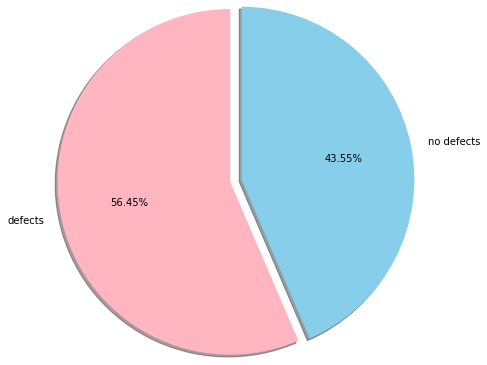

In [103]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.pie([total_defects, no_defects], (0.1, 0), ["defects", "no defects"], colors=['lightpink', 'skyblue'], autopct='%1.2f%%', shadow=True, startangle=90, radius=1.5)
plt.show()

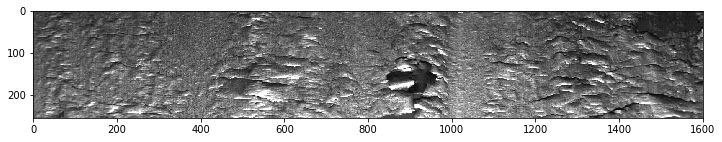

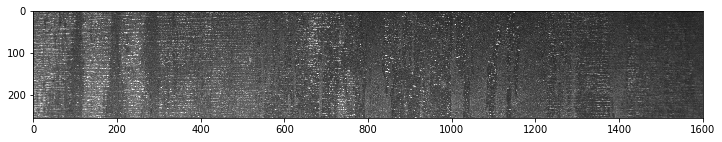

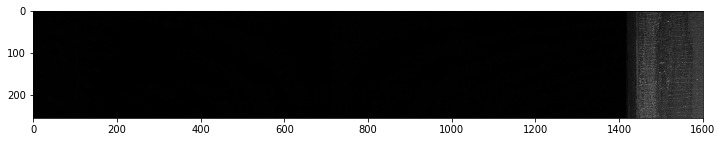

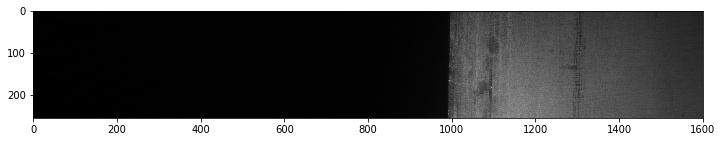

In [104]:
for i, image in enumerate(train_images[:10]):
    basename = os.path.basename(image)
    if basename not in df["ImageId"].values:
        plt.figure(i+1, figsize=(12, 18))
        plt.imshow(np.array(PIL.Image.open(image)))

In [105]:
class_counts = df["ClassId"].value_counts()

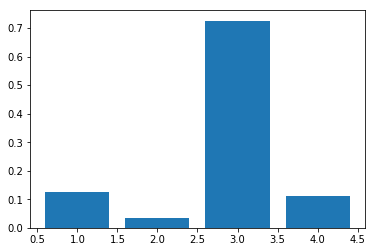

In [106]:
plt.bar(class_counts.index, (class_counts.values / total_defects))
plt.show()

In [107]:
labels_per_image = df.groupby('ImageId')['ClassId'].count().reset_index(name='count')
labels_per_image[labels_per_image["count"] > 2]

,ImageId,count
5740,db4867ee8.jpg,3
6253,ef24da2ba.jpg,3


In [108]:
images= []
class_id= []
for img in os.listdir(os.path.join(base_dir, "train_images")):
    images.append(img)
    class_id.append(1)
    images.append(img)
    class_id.append(2)
    images.append(img)
    class_id.append(3)
    images.append(img)
    class_id.append(4)
train_images= pd.DataFrame(images,columns=['ImageId'])
train_images['ClassId'] = class_id
print('train_images shape:', train_images.shape)
train_images.head()

train_images shape: (50272, 2)


,ImageId,ClassId
0,58ee62fd7.jpg,1
1,58ee62fd7.jpg,2
2,58ee62fd7.jpg,3
3,58ee62fd7.jpg,4
4,eeffa4c49.jpg,1


In [109]:
all_df = pd.merge(train_images, df, how='outer', on=['ImageId','ClassId'])
all_df = all_df.fillna('')
all_df[50:55]

,ImageId,ClassId,EncodedPixels
50,e5dfaf632.jpg,3,94587 7 94831 19 95075 31 95319 43 95563 55 95...
51,e5dfaf632.jpg,4,
52,194f48184.jpg,1,
53,194f48184.jpg,2,
54,194f48184.jpg,3,


In [110]:
all_df = pd.pivot_table(all_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
all_df = all_df.reset_index()
all_df.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']

In [111]:
all_df.to_csv(os.path.join(base_dir, "prep_data.csv"), index=False)

In [115]:
data = pd.read_csv(os.path.join(base_dir, "prep_data.csv"))
data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
1,00031f466.jpg,NaN,NaN,NaN,NaN
2,000418bfc.jpg,NaN,NaN,NaN,NaN
3,000789191.jpg,NaN,NaN,NaN,NaN
4,0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN


In [116]:
# Replace NAs with blank spaces
data.fillna('', inplace=True)
data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [117]:
def rle2mask(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

Sample images with Class 1 defect:


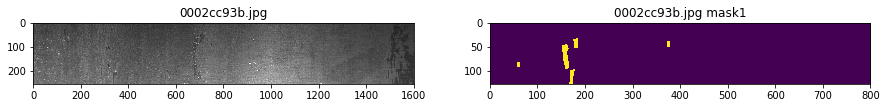

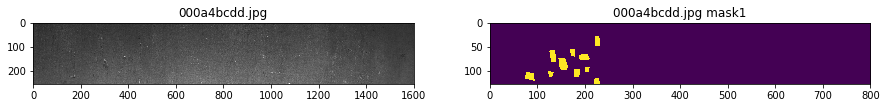

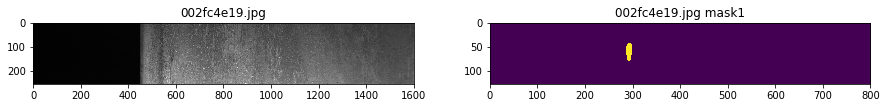

Sample images with Class 2 defect:


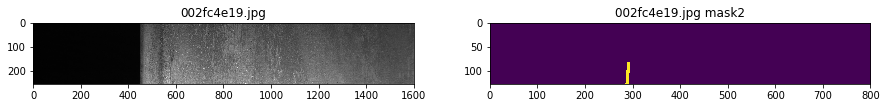

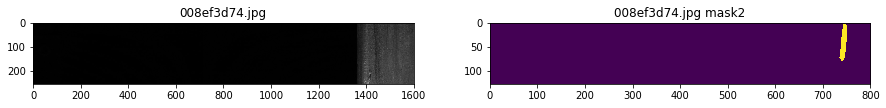

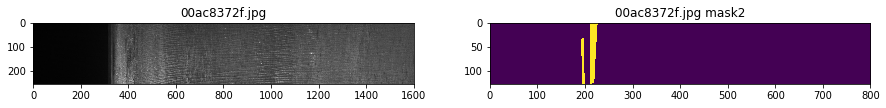

Sample images with Class 3 defect:


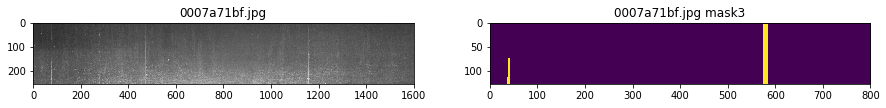

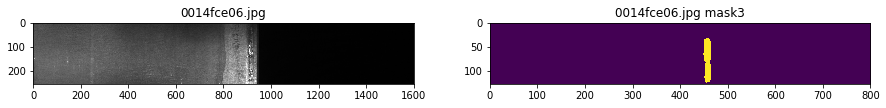

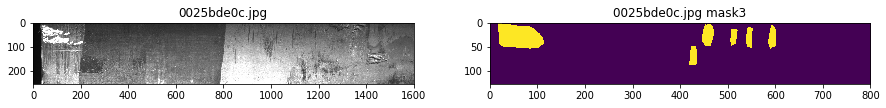

Sample images with Class 4 defect:


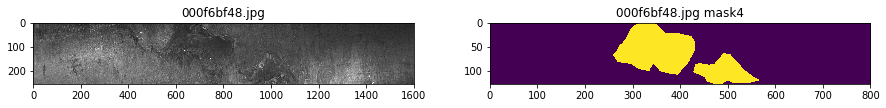

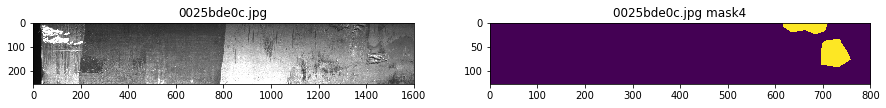

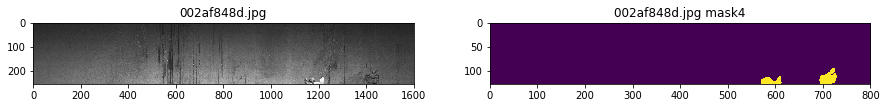

In [120]:
import cv2

for k in [1, 2, 3, 4]:
        cnt = 0
        print("Sample images with Class {} defect:".format(k))
        for i in data[data[f'Defect_{k}'] != ''][['ImageId', f'Defect_{k}']].values:
            if cnt < 3:
                fig, (ax1, ax2) = plt.subplots(
                    nrows=1, ncols=2, figsize=(15, 7))
                img = cv2.imread(os.path.join(base_dir, 'train_images', str(i[0])))
                ax1.imshow(img)
                ax1.set_title(i[0])
                cnt += 1
                ax2.imshow(rle2mask(i[1]))
                ax2.set_title(i[0]+' mask'+str(k))
                plt.show()

In [152]:
import tensorflow as tf

tf.random.set_seed(42)


def tfdata_generator(images, labels, is_training, batch_size=16, buffer_size=5000):
    '''Construct a data generator using tf.Dataset'''

    def parse_function(filename, labels):
        # reading image
        image_string = tf.io.read_file(filename)
        # decode image as tensor of dtype uint8
        image = tf.image.decode_jpeg(image_string, channels=3)

        # convert to float values in range [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [128, 800])  # resize to desired size

        # reading label masks
        y = tf.zeros((128, 800, 1), dtype=tf.float32)
        for j in range(4):
            mask_string = tf.io.read_file(labels[j])
            mask = tf.image.decode_jpeg(mask_string)
            mask = tf.image.convert_image_dtype(mask, tf.float32)

            y = tf.concat([y, mask], 2)

        return image, y[:, :, 1:]

    def flip(image, labels):
        image = tf.image.random_flip_left_right(image, seed=1)
        labels = tf.image.random_flip_left_right(labels, seed=1)
        image = tf.image.random_flip_up_down(image, seed=1)
        labels = tf.image.random_flip_up_down(labels, seed=1)

        return image, labels

    def color(image, labels):
        image = tf.image.random_hue(image, 0.05)
        image = tf.image.random_saturation(image, 0.4, 1.2)
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_contrast(image, 0.4, 1.2)

        return image, labels

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if is_training:
        dataset = dataset.shuffle(buffer_size)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.map(parse_function, num_parallel_calls=4)

    augmentations = [flip, color]

    if is_training:
        for f in augmentations:
            if tf.random.uniform([1], 0, 1) > 0.6:
                dataset = dataset.map(f, num_parallel_calls=4)

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [153]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1-dice_coef(y_true, y_pred))


def dice_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))


In [154]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow_examples.models.pix2pix import pix2pix

def conv2d_block(x, n_filters, kernel_size, block, batchnorm=False):
    for i in range(2):
        conv_name = f'{block}_conv{i+1}'
        bn_name = f'{block}_bn{i+1}'
        act_name = f'{block}_act{i+1}'

        x = layers.Conv2D(n_filters, kernel_size,
                          kernel_initializer='he_normal', padding='same', name=conv_name)(x)
        if batchnorm:
            x = layers.BatchNormalization(name=bn_name)(x)
        x = layers.ReLU(name=act_name)(x)

    return x


def downsample_network(input_shape, n_classes=2, pooling='max', include_top=False):
    img = layers.Input(shape=input_shape)

    c1 = conv2d_block(img, 32, kernel_size=3, batchnorm=True, block='block1')
    x = layers.MaxPooling2D((2, 2))(c1)
    x = layers.Dropout(0.4)(x)

    c2 = conv2d_block(x, 64, kernel_size=3, batchnorm=True, block='block2')
    x = layers.MaxPooling2D((2, 2))(c2)
    x = layers.Dropout(0.4)(x)

    c3 = conv2d_block(x, 128, kernel_size=3, batchnorm=True, block='block3')
    x = layers.MaxPooling2D((2, 2))(c3)
    x = layers.Dropout(0.4)(x)

    c4 = conv2d_block(x, 256, kernel_size=3, batchnorm=True, block='block4')
    x = layers.MaxPooling2D((2, 2))(c4)
    x = layers.Dropout(0.4)(x)

    c5 = conv2d_block(x, 512, kernel_size=3, batchnorm=True, block='block5')

    if include_top:
        x = layers.Flatten()(c5)
        x = layers.Dense(n_classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(c5)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(c5)

    return keras.Model(inputs=img, outputs=x, name='encoder')


def unet(input_shape, n_classes):
    # I particularly like this setup because it makes it very easy to
    # replace the encoder with any other arch without much efforts
    base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_layers)

    down_stack.trainable = False

    # downsampling path
    inputs = layers.Input(shape=input_shape)
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsampling path
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        n_classes, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [156]:
from sklearn.model_selection import train_test_split

def prepare_data(data, data_dir, split_ratio=0.15):
    train_data, val_data = train_test_split(
        data, test_size=split_ratio, random_state=1)

    # Prepare train data for tensorflow datasets
    train_ids = train_data['ImageId'].values
    train_img_paths = [os.path.join(
        data_dir, "train_images", i) for i in train_ids]
    train_mask_paths = [
        [os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask1.png"),
         os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask2.png"),
         os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask3.png"),
         os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask4.png")]
        for i in train_ids]

    # Prepare val data for tensorflow datasets
    val_ids = val_data['ImageId'].values
    val_img_paths = [os.path.join(data_dir, "train_images", i)
                     for i in val_ids]
    val_mask_paths = [
        [os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask1.png"),
         os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask2.png"),
         os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask3.png"),
         os.path.join(data_dir, "train_masks", i.split(".")[0] + "_mask4.png")]
        for i in val_ids]

    return train_img_paths, train_mask_paths, val_img_paths, val_mask_paths

In [ ]:
train_img_paths, train_mask_paths, val_img_paths, val_mask_paths = \
        prepare_data(data, base_dir)

# prepare data for model training
train_batches = tfdata_generator(
    train_img_paths, train_mask_paths, is_training=True, batch_size=8)
val_batches = tfdata_generator(
    val_img_paths, val_mask_paths, is_training=False, batch_size=8)

model = unet((128, 800, 3), 4)
model.compile(optimizer="adam", loss=bce_dice_loss, metrics=[dice_coef])

history = model.fit_generator(train_batches, validation_data=val_batches, epochs=10, verbose=1)